In [13]:
import os
import ramdom
import numpy as np
import yfinance as yf
import pandas as pd 
from statsmodels.regression.linear_model import OLS
import statsmodels.api as sm 
from matplotlib import pyplot as plt
%matplotlib inline
from pykalman import KalmanFilter
from datetime import datetime
from numpy import log, polyfit, sqrt, std, subtract
import statsmodels.tsa.stattools as ts
import ffn
import warnings
warnings.filterwarnings('ignore')

In [3]:
# data of stocks
stocks = ["ADBE",'MSFT']
start_date = "2020-01-01"
end_date= "2023-12-31"
df = yf.download(stocks,start=start_date,end=end_date)['Adj Close']
df.index = df.index = pd.to_datetime(df.index)
df.head()

[*********************100%***********************]  2 of 2 completed


Ticker,ADBE,MSFT
Date,,
2020-01-02,334.429993,153.938202
2020-01-03,331.809998,152.021378
2020-01-06,333.709991,152.414368
2020-01-07,333.390015,151.024673
2020-01-08,337.869995,153.430267


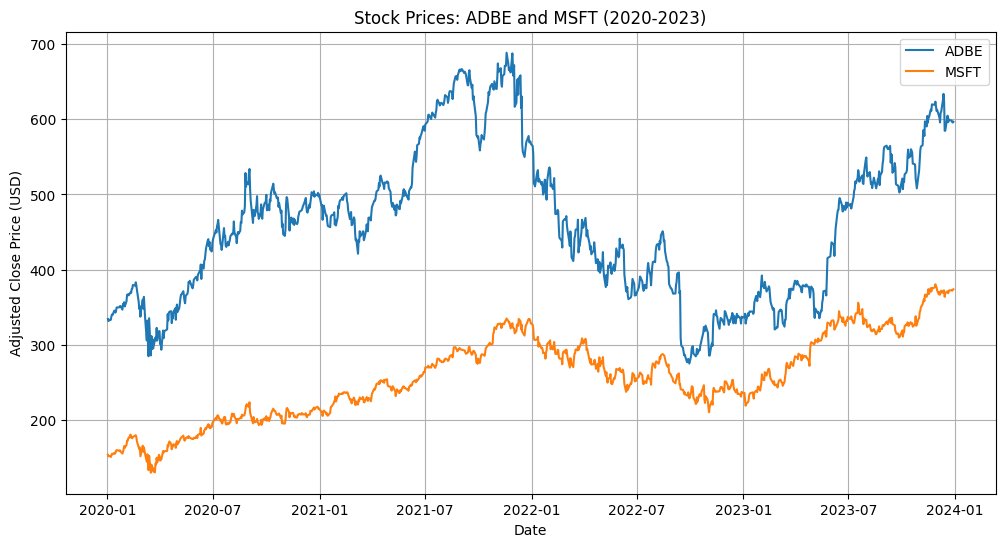

Ticker         ADBE         MSFT
count   1006.000000  1006.000000
mean     459.583559   257.154939
std      100.110992    55.451839
min      275.200012   130.140991
25%      373.617500   215.322418
50%      460.029999   253.862488
75%      519.614975   297.198029
max      688.369995   380.619812


In [4]:
# Plotting stock prices
plt.figure(figsize=(12, 6))
for stock in df.columns:
    plt.plot(df[stock], label=stock)

plt.title('Stock Prices: ADBE and MSFT (2020-2023)')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

# Summary statistics for both stocks
summary = df.describe()
print(summary)

/var/folders/1b/2j2qzyyx5cb5lppylsdkvd1r0000gn/T/ipykernel_5228/2130357638.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cb.ax.set_yticklabels([p.strftime('%Y-%m-%d') for p in df.index[tick_indices]])


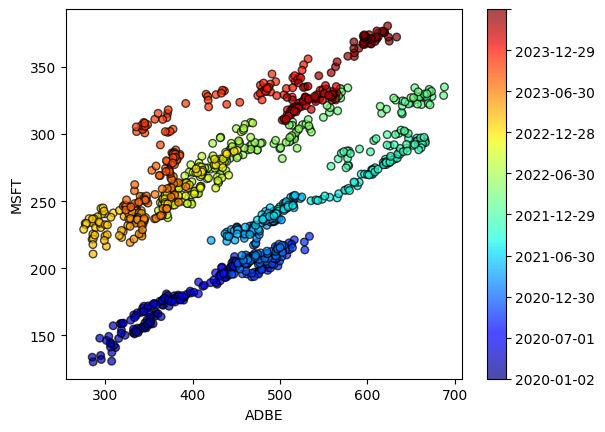

In [11]:
colors = np.linspace(0.1, 1, len(df))

sc = plt.scatter(df[stocks[0]], df[stocks[1]], s=30, 
                 c=colors, cmap=plt.get_cmap('jet'), edgecolor='k', alpha=0.7)

cb = plt.colorbar(sc)
tick_indices = np.linspace(0, len(df) - 1, 9, dtype=int)
cb.ax.set_yticklabels([p.strftime('%Y-%m-%d') for p in df.index[tick_indices]])
plt.xlabel(stocks[0])
plt.ylabel(stocks[1])
plt.show()


In [15]:

def hurst(ts):
    """Returns the Hurst Exponent of the time series vector ts"""
    # Create the range of lag values
    lags = range(2, 100)

    # Calculate the array of the variances of the lagged differences
    tau = [sqrt(std(subtract(ts[lag:], ts[:-lag]))) for lag in lags]

    # Use a linear fit to estimate the Hurst Exponent
    poly = polyfit(log(lags), log(tau), 1)

    # Return the Hurst exponent from the polyfit output
    return poly[0]*2.0

#--------------------------------------------------------------------------------------

def half_life(spread):
    spread_lag = spread.shift(1)
    spread_lag.iloc[0] = spread_lag.iloc[1]

    spread_ret = spread - spread_lag
    spread_ret.iloc[0] = spread_ret.iloc[1]

    spread_lag2 = sm.add_constant(spread_lag)

    model = sm.OLS(spread_ret,spread_lag2)
    res = model.fit()
    halflife = int(round(-np.log(2) / res.params[1],0))

    if halflife <= 0:
        halflife = 1
    return halflife

#--------------------------------------------------------------------------------------

def KalmanFilterAverage(x):
    # Construct a Kalman filter
    from pykalman import KalmanFilter
    kf = KalmanFilter(transition_matrices = [1],
                      observation_matrices = [1],
                      initial_state_mean = 0,
                      initial_state_covariance = 1,
                      observation_covariance=1,
                      transition_covariance=.01)

    # Use the observed values of the price to get a rolling mean
    state_means, _ = kf.filter(x.values)
    state_means = pd.Series(state_means.flatten(), index=x.index)
    return state_means

#--------------------------------------------------------------------------------------

#  Kalman filter regression
def KalmanFilterRegression(x,y):

    delta = 1e-3
    trans_cov = delta / (1 - delta) * np.eye(2) # How much random walk wiggles
    obs_mat = np.expand_dims(np.vstack([[x], [np.ones(len(x))]]).T, axis=1)

    kf = KalmanFilter(n_dim_obs=1, n_dim_state=2, # y is 1-dimensional, (alpha, beta) is 2-dimensional
                      initial_state_mean=[0,0],
                      initial_state_covariance=np.ones((2, 2)),
                      transition_matrices=np.eye(2),
                      observation_matrices=obs_mat,
                      observation_covariance=2,
                      transition_covariance=trans_cov)

    # Use the observations y to get running estimates and errors for the state parameters
    state_means, state_covs = kf.filter(y.values)
    return state_means

#--------------------------------------------------------------------------------------

def backtest(s1, s2, x, y):
    # INPUT:
    # s1: the symbol of contract one
    # s2: the symbol of contract two
    # x: the price series of contract one
    # y: the price series of contract two

    # OUTPUT:
    # df1['cum rets']: cumulative returns in pandas data frame
    # sharpe: sharpe ratio

    # Run regression to find hedge ratio and intercept, then create spread series
    df1 = pd.DataFrame({'y': y, 'x': x})
    state_means = KalmanFilterRegression(KalmanFilterAverage(x), KalmanFilterAverage(y))

    df1['hr'] = -state_means[:, 0]  # Hedge ratio (b)
    df1['intercept'] = -state_means[:, 1]  # Intercept (a)
    
    # Calculate spread as y - bx - a
    df1['spread'] = df1.y + (df1.x * df1.hr) + df1.intercept

    ##############################################################

    halflife = half_life(df1['spread'])

    ##############################################################

    meanSpread = df1.spread.rolling(window=halflife).mean()
    stdSpread = df1.spread.rolling(window=halflife).std()

    df1['zScore'] = (df1.spread - meanSpread) / stdSpread

    ##############################################################

    entryZscore = 2
    exitZscore = 0

    # Set up num units long
    df1['long entry'] = ((df1.zScore < -entryZscore) & (df1.zScore.shift(1) > -entryZscore))
    df1['long exit'] = ((df1.zScore > -exitZscore) & (df1.zScore.shift(1) < -exitZscore))
    df1['num units long'] = np.nan
    df1.loc[df1['long entry'], 'num units long'] = 1
    df1.loc[df1['long exit'], 'num units long'] = 0
    df1['num units long'][0] = 0
    df1['num units long'] = df1['num units long'].fillna(method='pad')

    # Set up num units short
    df1['short entry'] = ((df1.zScore > entryZscore) & (df1.zScore.shift(1) < entryZscore))
    df1['short exit'] = ((df1.zScore < exitZscore) & (df1.zScore.shift(1) > exitZscore))
    df1.loc[df1['short entry'], 'num units short'] = -1
    df1.loc[df1['short exit'], 'num units short'] = 0
    df1['num units short'][0] = 0
    df1['num units short'] = df1['num units short'].fillna(method='pad')

    df1['numUnits'] = df1['num units long'] + df1['num units short']
    df1['spread pct ch'] = (df1['spread'] - df1['spread'].shift(1)) / ((df1['x'] * abs(df1['hr'])) + df1['y'])
    df1['port rets'] = df1['spread pct ch'] * df1['numUnits'].shift(1)

    df1['cum rets'] = (1 + df1['port rets']).cumprod()

    try:
        sharpe = ((df1['port rets'].mean() / df1['port rets'].std()) * sqrt(252))
    except ZeroDivisionError:
        sharpe = 0.0

    #############################################################
    return df1['cum rets'], sharpe


In [17]:
# Split the data into training and test sets
train_size = int (len(df) * 0.8)
train_df = df[ :train_size]
test_df = df[train_size: ]

test_df.head()

Ticker,ADBE,MSFT
Date,,
2023-03-14,333.329987,257.736786
2023-03-15,333.609985,262.332336
2023-03-16,353.290009,272.966339
2023-03-17,358.140015,276.158508
2023-03-20,362.880005,269.042847


Text(0, 0.5, 'intercept')

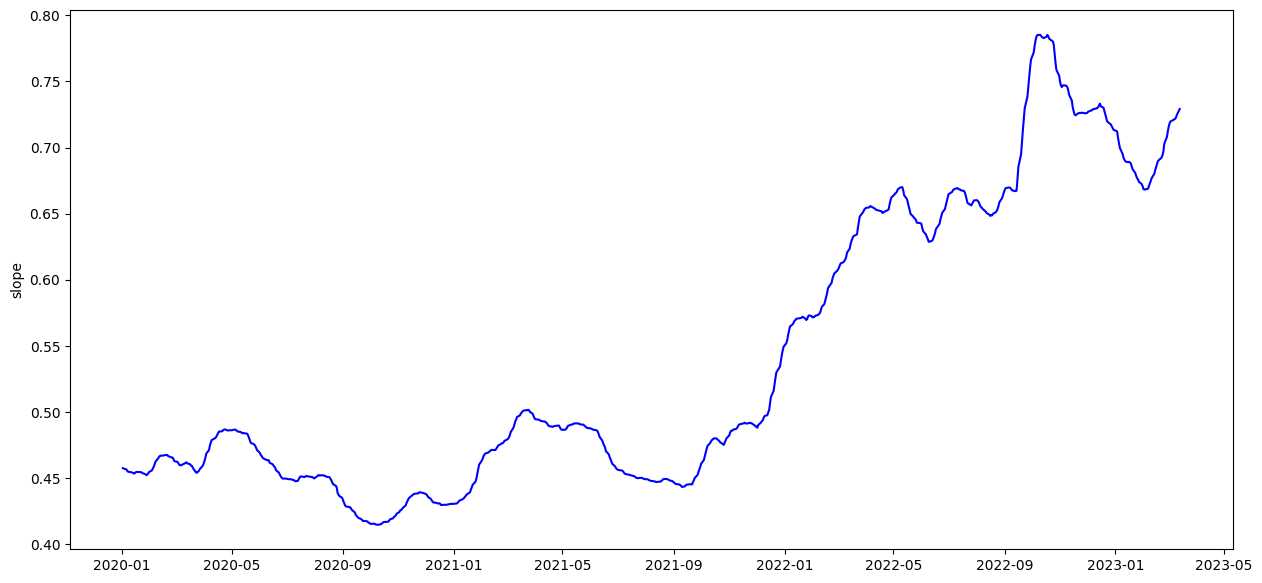

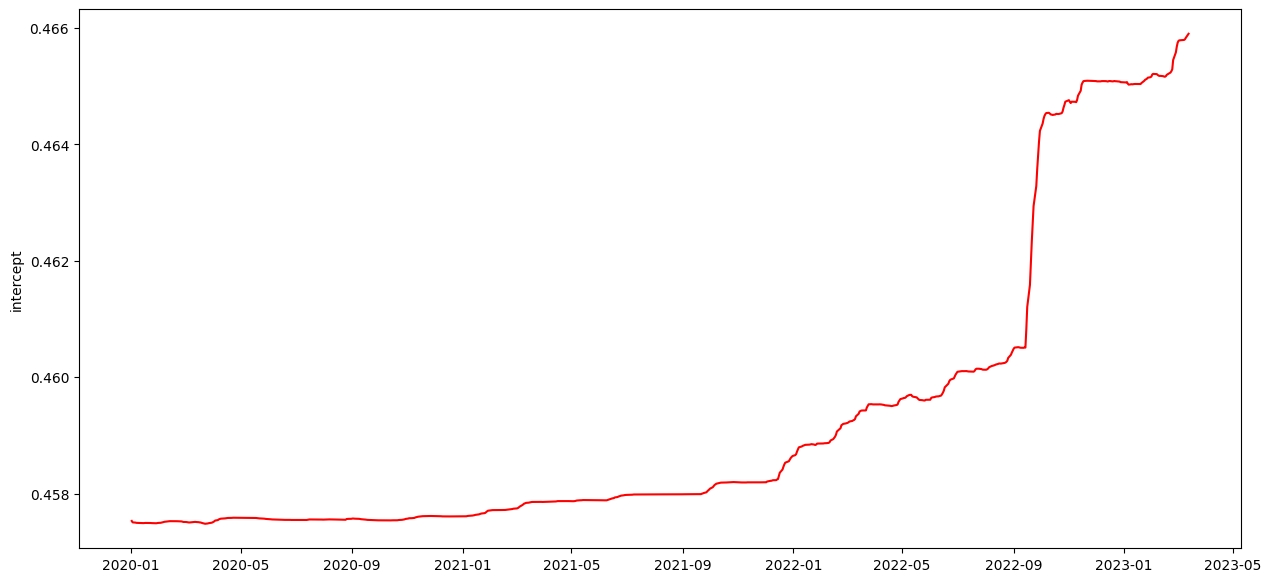

In [20]:
state_means_train = KalmanFilterRegression(KalmanFilterAverage(train_df[stocks[0]]), KalmanFilterAverage(train_df[stocks[1]]))

slope=state_means_train[:, 0] 
intercept=state_means_train[:, 1]
plt.figure(figsize =(15,7))
plt.plot(train_df[stocks[1]].index, slope, c='b')
plt.ylabel('slope')
plt.figure(figsize =(15,7))
plt.plot(train_df[stocks[1]].index,intercept,c='r')
plt.ylabel('intercept')

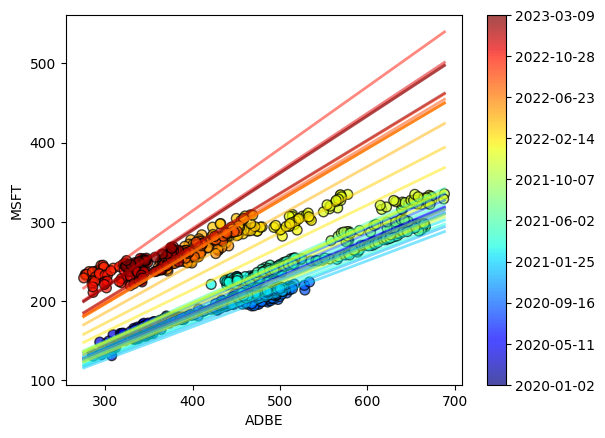

In [22]:
def visualize_correlation_with_regression(data_all, tickers, state_means, step=25):

    # Generate color mapping based on the time index
    dates = [str(p.date()) for p in data_all[::len(data_all) // 10].index]
    colors = np.linspace(0.1, 1, len(data_all))

    # Scatter plot of the asset prices
    sc = plt.scatter(
        data_all[tickers[0]], data_all[tickers[1]], 
        s=50, c=colors, cmap=plt.get_cmap('jet'), edgecolor='k', alpha=0.7
    )
    cb = plt.colorbar(sc)
    cb.ax.set_yticklabels([str(p.date()) for p in data_all[::len(data_all) // 9].index])
    plt.xlabel(tickers[0])
    plt.ylabel(tickers[1])

    # Add regression lines
    xi = np.linspace(data_all[tickers[0]].min(), data_all[tickers[0]].max(), 2)
    colors_l = np.linspace(0.1, 1, len(state_means[::step]))
    for i, b in enumerate(state_means[::step]):
        plt.plot(xi, b[0] * xi + b[1], alpha=0.5, lw=2, c=plt.get_cmap('jet')(colors_l[i]))

    # Show the plot
    plt.show()

visualize_correlation_with_regression(train_df, stocks, state_means_train, step=25)


In [26]:
ret, sharp_test = backtest(stocks[0], stocks[1], test_df['ADBE'], test_df['MSFT'])


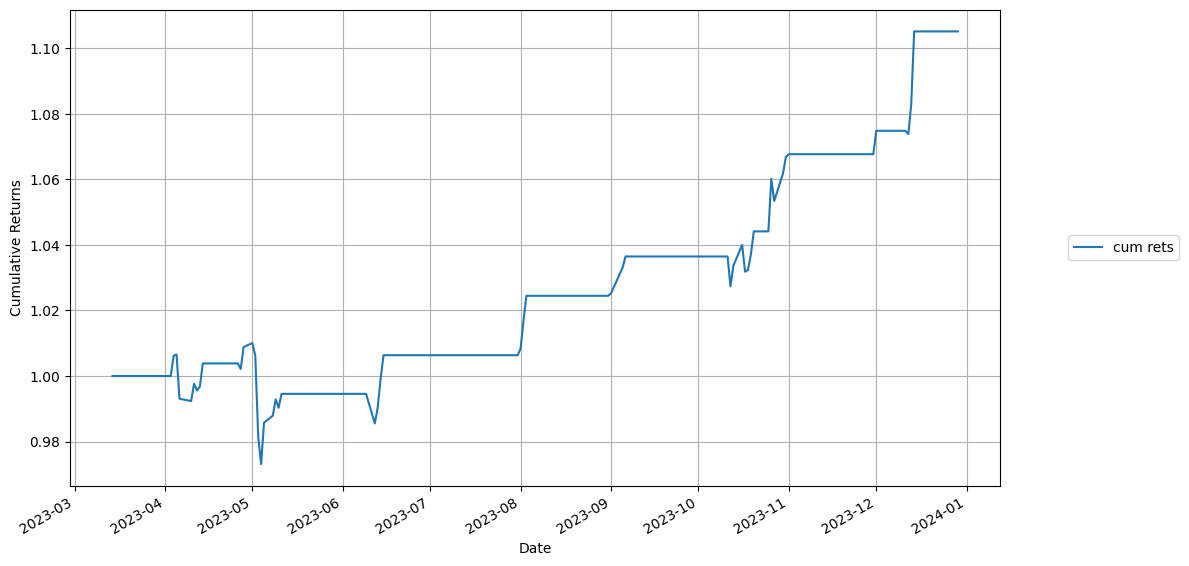

In [27]:
# Show the results of in-sample testing
ret.iloc[0] = 1
ret.index = test_df.index
ret.plot(figsize=(12,7),grid=True)
plt.legend(loc='center right', bbox_to_anchor=(1.2, 0.5))
plt.ylabel('Cumulative Returns')
plt.show()


In [28]:
# Calculate the performance
perf = ret.calc_stats()
perf.display()

Stats for cum rets from 2023-03-14 00:00:00 - 2023-12-29 00:00:00
Annual risk-free rate considered: 0.00%
Summary:
Total Return      Sharpe  CAGR    Max Drawdown
--------------  --------  ------  --------------
10.51%              2.13  13.42%  -3.66%

Annualized Returns:
mtd    3m     6m     ytd     1y    3y    5y    10y    incep.
-----  -----  -----  ------  ----  ----  ----  -----  --------
3.51%  6.62%  9.82%  10.51%  -     -     -     -      13.42%

Periodic:
        daily    monthly    yearly
------  -------  ---------  --------
sharpe  2.13     2.58       -
mean    12.71%   13.52%     -
vol     5.97%    5.24%      -
skew    -0.34    0.03       -
kurt    15.61    -0.08      -
best    2.05%    3.51%      -
worst   -2.45%   -1.42%     -

Drawdowns:
max     avg       # days
------  ------  --------
-3.66%  -1.24%     20.83

Misc:
---------------  ------
avg. up month    1.65%
avg. down month  -0.71%
up year %        -
12m up %         -
---------------  ------
